
=== valve1-0 === [405.0/1154]==================================================

===== SubID Change Detector ===================================================
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Iter 16
Iter 17
Iter 18
Iter 19
Iter 20
Iter 21
Iter 22
Iter 23
Iter 24
Iter 25
Iter 26
Iter 27
Iter 28
Iter 29
Iter 30
Iter 31
Iter 32
Iter 33
Iter 34
Iter 35
Iter 36
Iter 37
Iter 38
Iter 39
Iter 40
Iter 41
Iter 42
Iter 43
Iter 44
Iter 45
Iter 46
Iter 47
Iter 48
Iter 49
Iter 50
Iter 51
Iter 52
Iter 53
Iter 54
Iter 55
Iter 56
optimizer 12 wants to register: {}.
optimizer 12 got 0.0 as target.
optimizer 12 will register next: {'params': {'DMDOptSubIDChangeDetector__ref_size__round': 137.41476701653167, 'DMDOptSubIDChangeDetector__test_size__round': 173.17131903480194, 'DMDOptSubIDChangeDetector__threshold': 8.615917368689715, 'Hankelizer__w__round': 1.830319437275604, 'OnlineDMD__eig_rtol': 9.391592325551192, 'OnlineDM

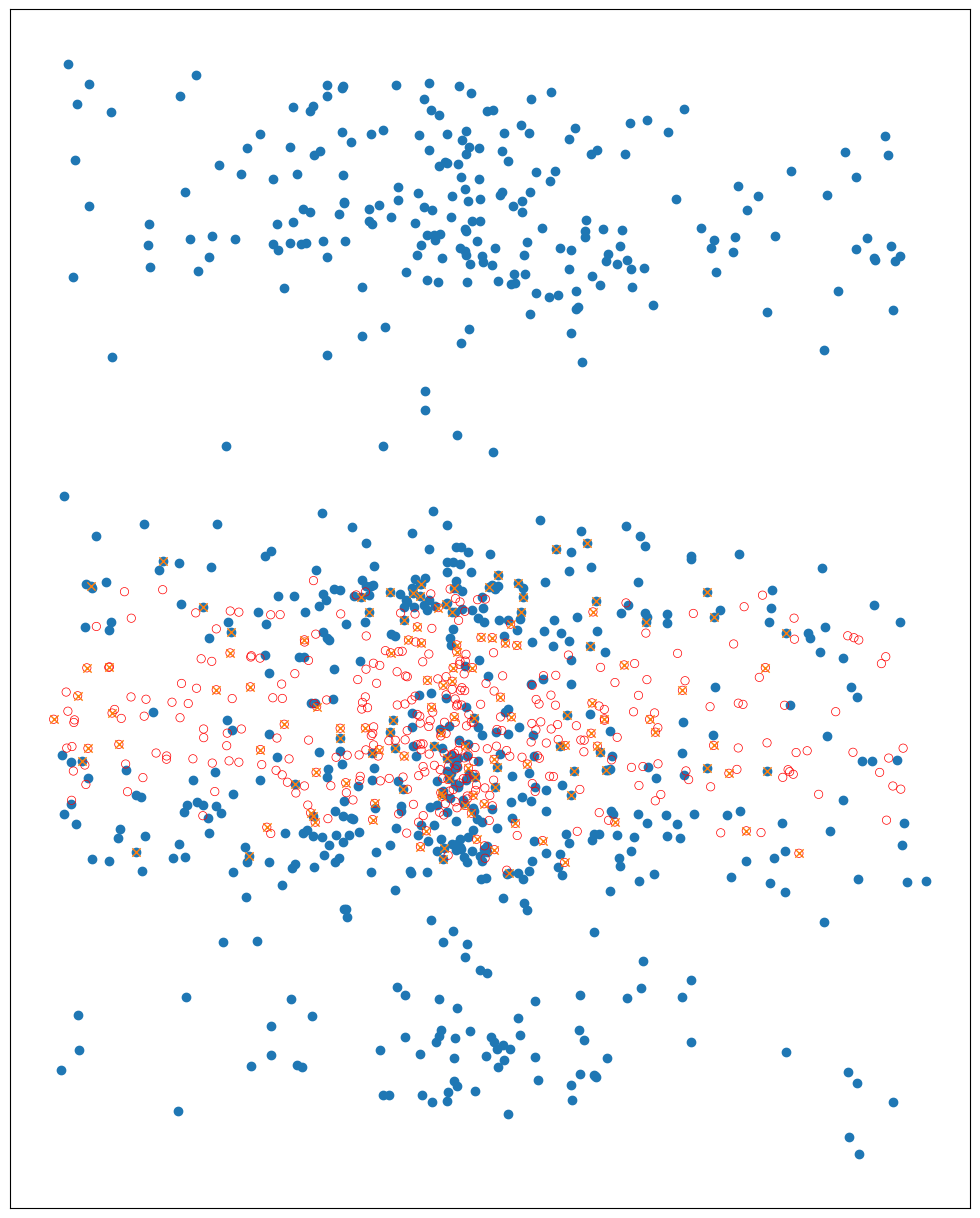

: 

In [1]:
# IMPORTS
import os
import random
import sys
import warnings

from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from river import anomaly, preprocessing
from river.decomposition import OnlineDMD
from river.metrics import F1
from river.utils import Rolling
from sklearn.decomposition import PCA

sys.path.insert(1, str(Path().resolve().parent))
from functions.bayes_opt_parallel import BayesianOptimization  # noqa: E402
from functions.datasets import load_skab  # noqa: E402
from functions.compose import build_model, convert_to_nested_dict  # noqa: E402
from functions.chdsubid import DMDOptSubIDChangeDetector  # noqa: E402
from functions.evaluate import (  # noqa: E402
    build_fit_evaluate,
    print_stats,
    progressive_val_predict,
)

%load_ext autoreload
%autoreload 2

# CONSTANTS
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


# FUNCTIONS
def get_random_samples(df: pd.DataFrame, num_samples=10000):
    if len(df) <= num_samples:
        return df
    else:
        return df.sample(n=num_samples, random_state=RANDOM_STATE)


def plot_detection(df: pd.DataFrame, y_pred):
    df["pred"] = y_pred
    if "anomaly" in df.columns:
        df = get_random_samples(df)
        if len(df.columns) >= 4:
            # Separate the feature columns from the target column ("anomaly")
            X = df.drop(columns=["anomaly", "pred"])
            y = df["anomaly"]
            y_pred = df["pred"]

            # Apply PCA to reduce the feature columns to 2 components
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)

            # Create a new DataFrame with the reduced components and "anomaly" column
            df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
            df_pca["anomaly"] = y.values
            df_pca["pred"] = y_pred.values
        else:
            print(True)
            df_pca = pd.DataFrame(df.reset_index().copy())
            df_pca.columns = ["PC1", "PC2", "anomaly", "pred"]

        # Plot the 2D scatter plot
        plt.scatter(
            df_pca[df_pca["anomaly"] == 0]["PC1"],
            df_pca[df_pca["anomaly"] == 0]["PC2"],
        )
        plt.scatter(
            df_pca[df_pca["anomaly"] == 1]["PC1"],
            df_pca[df_pca["anomaly"] == 1]["PC2"],
            facecolors="none",
            edgecolors="r",
            linewidths=0.5,
        )
        plt.scatter(
            df_pca[df_pca["pred"] == 1]["PC1"],
            df_pca[df_pca["pred"] == 1]["PC2"],
            marker="x",  # type: ignore
            linewidths=1,
        )  # type: ignore
        plt.xticks(())
        plt.yticks(())


def save_results_y(df_ys, path):
    os.makedirs(path, exist_ok=True)
    df_ys.to_csv(f"{path}/ys.csv", index=False)


def save_results_metrics(metrics_res, path):
    os.makedirs(path, exist_ok=True)
    metrics_res.to_csv(f"{path}/metrics.csv")


# MODS
class QuantileFilter(anomaly.QuantileFilter):
    def __init__(
        self, anomaly_detector, q: float, protect_anomaly_detector=True
    ):
        super().__init__(
            anomaly_detector=anomaly_detector,
            protect_anomaly_detector=protect_anomaly_detector,
            q=q,
        )

    def predict_one(self, *args):
        score = self.score_one(*args)
        return self.classify(score)


# SETTINGS

# DETECTION ALGORITHMS
detection_algorithms = [
    (
        "SubID Change Detector",
        [
            preprocessing.Hankelizer,
            [DMDOptSubIDChangeDetector, [Rolling, OnlineDMD]],
        ],
        {
            "Hankelizer__w__round": (1, 30),
            "Rolling__window_size__round": (50, 10000),
            "DMDOptSubIDChangeDetector__ref_size__round": (50, 200),
            "DMDOptSubIDChangeDetector__test_size__round": (50, 200),
            "DMDOptSubIDChangeDetector__threshold": (0.0001, 10),
            "OnlineDMD__r__round": (2, 6),
            "OnlineDMD__eig_rtol": (0, 1e1),
        },
    ),
    # (
    #     "One-Class SVM",
    #     [preprocessing.StandardScaler, [QuantileFilter, anomaly.OneClassSVM]],
    #     {
    #         "QuantileFilter__q": (0.65, 0.99994),
    #         "OneClassSVM__intercept_lr": (0.005, 0.02),
    #     },
    # ),
    # (
    #     "Half-Space Trees",
    #     [preprocessing.MinMaxScaler, [QuantileFilter, anomaly.HalfSpaceTrees]],
    #     {
    #         "QuantileFilter__q": (0.65, 0.99994),
    #         "HalfSpaceTrees__n_trees__round": (1, 20),
    #         "HalfSpaceTrees__height__round": (1, 16),
    #         "HalfSpaceTrees__window_size__round": (100, 400),
    #     },
    # ),
    # (   "Local Outlier Factor",
    #     [[QuantileFilter, anomaly.LocalOutlierFactor]],
    #     {
    #         "QuantileFilter__q": (0.85, 0.99994),
    #         "LocalOutlierFactor__n_neighbors__round": (0,200),
    #         }
    #     ),
]

# DATASETS
# Read data
dfs = load_skab("data/skab")
dfs_free = [
    df
    for key, df_group in dfs.items()
    for df in df_group
    if key == "anomaly-free"
]
datasets: list[dict] = [
    {
        "name": f"{key}-{i}",
        "data": pd.DataFrame(df),
        "anomaly_col": "anomaly",
        "drop": "changepoint",
    }
    for key, df_group in dfs.items()
    for i, df in enumerate(df_group)
    if key != "anomaly-free"
][0:1]
for df in datasets:
    df["data"].index = pd.to_datetime(df["data"].index)

# PLOT CONFIG
plt.figure(figsize=(len([1, 1, 1]) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)
plot_num = 1

# RUN
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for dataset in datasets:
        # PREPROCESS DATA
        df = dataset["data"]
        df.index = pd.to_timedelta(
            range(0, len(df)), "T"
        ) + pd.Timestamp.utcnow().replace(microsecond=0)
        if isinstance(dataset["anomaly_col"], str):
            df = df.rename(columns={dataset["anomaly_col"]: "anomaly"})
        elif isinstance(dataset["anomaly_col"], pd.Series):
            df_y = dataset["anomaly_col"]
            df["anomaly"] = df_y.rename("anomaly").values
        if dataset["drop"] is not None:
            df = df.drop(columns=dataset["drop"])
        print(
            f"\n=== {dataset['name']} === [{sum(df['anomaly'])}/{len(df)}]".ljust(
                80, "="
            )
        )

        df_ys = df[["anomaly"]].copy()
        # RUN EACH MODEL AGAINST DATASET
        for alg in detection_algorithms:
            print(f"\n===== {alg[0]} ".ljust(80, "="))
            # INITIALIZE OPTIMIZER
            pbounds = alg[2]
            mod_fun = partial(
                build_fit_evaluate,
                alg[1],
                df,
                F1(),
                map_cluster_to_rc=False,
                drop_no_support=False,
            )

            # TUNE HYPERPARAMETERS
            optimizer = BayesianOptimization(
                f=mod_fun,
                pbounds=pbounds,
                verbose=2,
                random_state=RANDOM_STATE,
                allow_duplicate_points=True,
            )
            logger = JSONLogger(
                path=f"./.results/{dataset['name']}-{alg[0]}.log"
            )
            optimizer.subscribe(Events.OPTIMIZATION_END, logger)
            optimizer.maximize(init_points=56, n_iter=100, n_jobs=56)
            params = convert_to_nested_dict(optimizer.max["params"])
            print(params)
            model = build_model(alg[1], params)
            if hasattr(model, "seed"):
                model.seed = RANDOM_STATE  # type: ignore
            if hasattr(model, "random_state"):
                model.random_state = RANDOM_STATE  # type: ignore
            # USE TUNED MODEL
            # PROGRESSIVE PREDICT
            y_pred, _ = progressive_val_predict(model, df, metrics=None)

            # SAVE PREDICITONS
            df_ys[f"{alg[0]}__{params}"] = y_pred

            #  PRINT OUT LAST DETECTION RESULTS
            print_stats(df, y_pred)
            plt.subplot(len(datasets), len(detection_algorithms), plot_num)
            plot_detection(df, y_pred)
            plot_num += 1

        # LOAD RESULTS
        #  Save
        dir_path = f".results/{dataset['name']}"
        save_results_y(df_ys, f".results/{dataset['name']}")

plt.show()

In [ ]:
import sys

from pathlib import Path

from river.metrics import (
    F1,
    Precision,
    Recall,
    ROCAUC,
    RollingROCAUC,
    ClassificationReport,
)
from river.stats import Mean

sys.path.insert(1, str(Path().resolve().parent))
from functions.evaluate import batch_save_evaluate_metrics


class MeanRollingROCAUC(RollingROCAUC):
    def __init__(self, window_size=1000, pos_val=True):
        super().__init__(window_size, pos_val)
        self.mean = Mean()

    def update(self, y_true, y_pred):
        super().update(y_true, y_pred)
        self.mean.update(super().get())
        return self

    def get(self):
        return self.mean.get()


metrics = [
    Precision(),
    Recall(),
    F1(),
    ROCAUC(),
    MeanRollingROCAUC(),
    ClassificationReport(),
]

path = ".results/"

batch_save_evaluate_metrics(metrics, path, task="classification")